In [26]:
import re
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.utils import flow_to_image

In [3]:
class SkyDataset(Dataset):
    def __init__(self, train_dir, gt_dir):
        self.train_dir = train_dir
        self.gt_dir = gt_dir
        
        self.gt_imgs = os.listdir(gt_dir) # image filename
        self.gt_paths = [os.path.join(self.gt_dir, self.gt_imgs[x]) for x in range(len(self.gt_imgs))] # total path
        
        self.gt = []
        self.train = []
        
        pattern = r'^([A-Za-z0-9_-]+)\_\d+\.jpg$'
        for idx, gt_img_fname in enumerate(self.gt_imgs):
            match = re.search(pattern, gt_img_fname)
            if match:
                data_folder = match.group(1)    
                data_imgs = sorted(os.listdir(os.path.join(self.train_dir, data_folder, gt_img_fname[:-4])))
                data_paths = [os.path.join(self.train_dir, data_folder, gt_img_fname[:-4], x) for x in data_imgs]
                if len(data_paths) > 5:
                    self.gt.append(self.gt_paths[idx])
                    self.train.append(data_paths)

    def __len__(self):
        return len(self.gt)
    
    def __getitem__(self, idx):
        train_seq = torch.stack([read_image(x)/255.0 for x in self.train[idx][:5]])
        gt_image = read_image(self.gt[idx])/255.0
        
        return train_seq, gt_image

In [11]:
train_set = SkyDataset('/kaggle/input/aps360-sky-train-dataset/sky_train', '/kaggle/input/aps360-sky-train-dataset/ground_truth/ground_truth')
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)

## Visualizing Input Sequence and Output Image

torch.Size([1, 5, 3, 360, 640]) torch.Size([1, 3, 360, 640])


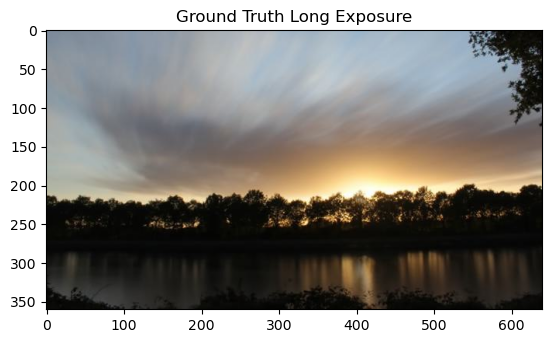

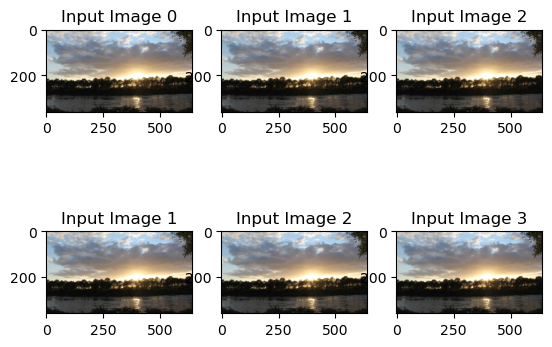

In [47]:
in_seq, gt_img = next(iter(train_dataloader))
print(in_seq.shape, gt_img.shape)
plt.imshow(gt_img[0].squeeze().permute(1, 2, 0))
plt.title('Ground Truth Long Exposure')
plt.show()
f, axarr = plt.subplots(2,3) 
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(in_seq[0].squeeze()[0].cpu().permute(1, 2, 0))
        axarr[i][j].set_title(f'Input Image {i+j}')

## Visualizing Optical Flow

We'll use the first sequence of the batch.

We assume the motion field of a sequence stays constant, which is reasonable since fields in nature vary little when averaged across time.

Thus, we can estimate the motion field but just using first two images of the input sequence.

One method is to use optical flow as shown in this PyTorch tutorial: https://pytorch.org/vision/main/auto_examples/plot_optical_flow.html

We'll try it on our dataset

In [29]:
from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
from torchvision.utils import flow_to_image
from torchvision import transforms

weights = Raft_Small_Weights.DEFAULT
flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False)
flow_model = flow_model.eval()
flow_tf = weights.transforms()

Text(0.5, 1.0, 'Optical Flow')

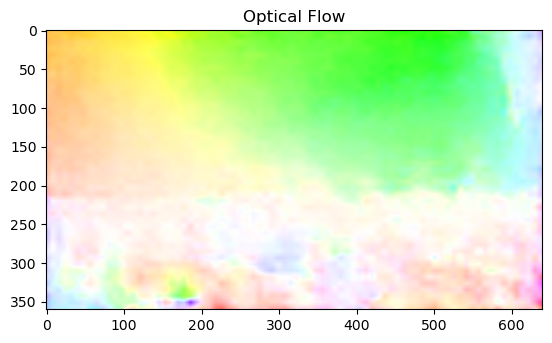

In [48]:
b1 = in_seq[0, 0].unsqueeze(0)
b2 = in_seq[0, 1].unsqueeze(0)
b1, b2 = flow_tf(b1, b2)
flow = torch.stack(flow_model(b1, b2))
flow = flow[-1]
flow_img = flow_to_image(flow[-1])
plt.imshow(flow_img.squeeze().permute(1, 2, 0))
plt.title('Optical Flow')